In [49]:
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter(x, y, bins=50):
    fig = plt.figure(figsize=(10, 10))
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    plt.show()

In [38]:
#rays_x = np.loadtxt("rays_x.dat")
#m = np.logical_and(np.abs(rays_y[:,0]) < 100, np.abs(rays_y[:,1]) < 100)
#x = rays_x[:,0][m]
#y = rays_x[:,1][m]
#density_scatter(x, y, bins = [30,30] )

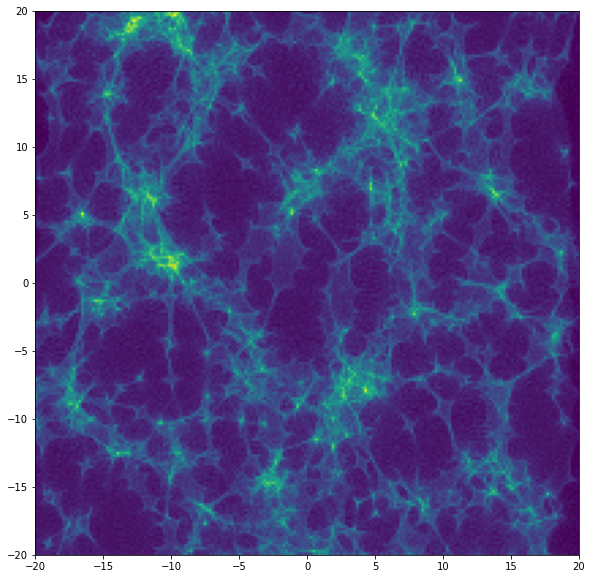

In [50]:
rays_y = np.loadtxt("rays_y.dat")
m = np.logical_and(np.abs(rays_y[:,0]) <= 20, np.abs(rays_y[:,1]) <= 20)
x = rays_y[:,0][m]
y = rays_y[:,1][m]
density_scatter(x, y, bins=[200, 200])

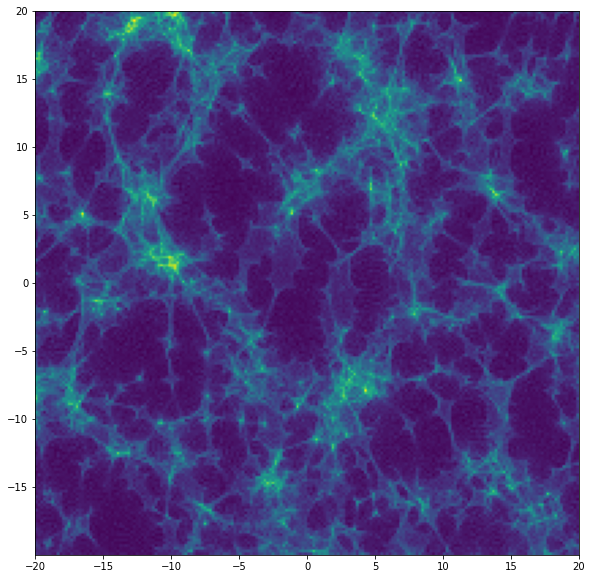

In [72]:
rays_y = np.loadtxt("rays_y_0.00.dat")
m = np.logical_and(np.abs(rays_y[:,0]) <= 20, np.abs(rays_y[:,1]) <= 20)
x = rays_y[:,0][m]
y = rays_y[:,1][m]
density_scatter(x, y, bins=[200, 200])

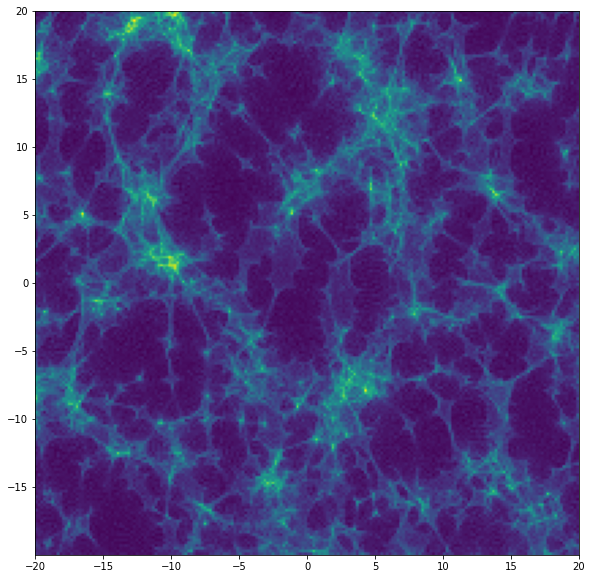

In [77]:
rays_y = np.loadtxt("rays_y_0.00.dat")
m = np.logical_and(np.abs(rays_y[:,0]) <= 20, np.abs(rays_y[:,1]) <= 20)
x = rays_y[:,0][m]
y = rays_y[:,1][m]
density_scatter(x, y, bins=[200, 200])